# **AIML Module Project - Computer Vision 2** - Total Score 60

## Lakshman Kumar S

# Part A - 20 Marks

**• DOMAIN:** Entertainment

**• CONTEXT:** Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved.

**• DATA DESCRIPTION:** The dataset comprises of images and its mask for corresponding human face.

**• PROJECT OBJECTIVE:** To build a face detection system.

### Steps and tasks: [ Total Score: 20 Marks]

#### 1. Import and Understand the data [7 Marks]


In [1]:
#tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.3.0'

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import random
from tensorflow.keras import backend
random.seed(1)
np.random.seed(1) 
tf.random.set_seed(1)
warnings.filterwarnings("ignore")

##### A. Import and read ‘images.npy’. [1 Marks]


In [3]:
data = np.load('images.npy', allow_pickle=True)

In [4]:
print("Shape of Data \n", data.shape)

Shape of Data 
 (409, 2)


In [5]:
images_df = pd.DataFrame(data)

In [6]:
images_df.head()

0  \
0  [[[42, 37, 34], [56, 51, 48], [71, 66, 63], [7...   
1  [[[207, 216, 227, 255], [206, 216, 227, 255], ...   
2  [[[91, 61, 33], [95, 65, 37], [94, 64, 38], [9...   
3  [[[0, 0, 0, 255], [0, 0, 0, 255], [0, 0, 0, 25...   
4  [[[250, 250, 250], [250, 250, 250], [250, 250,...   

                                                   1  
0  [{'label': ['Face'], 'notes': '', 'points': [{...  
1  [{'label': ['Face'], 'notes': '', 'points': [{...  
2  [{'label': ['Face'], 'notes': '', 'points': [{...  
3  [{'label': ['Face'], 'notes': '', 'points': [{...  
4  [{'label': ['Face'], 'notes': '', 'points': [{...

##### B. Split the data into Features(X) & labels(Y). Unify shape of all the images. [3 Marks]

 Imp Note: Replace all the pixels within masked area with 1.
 
 Hint: X will comprise of array of image whereas Y will comprise of coordinates of the mask(human face). Observe: data[0], data[0][0], data[0][1].


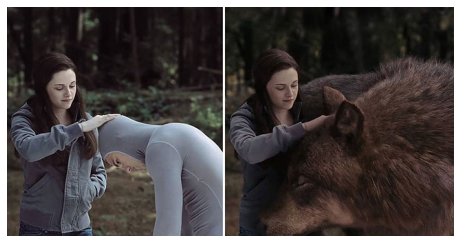

In [7]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[0][0])
plt.show()

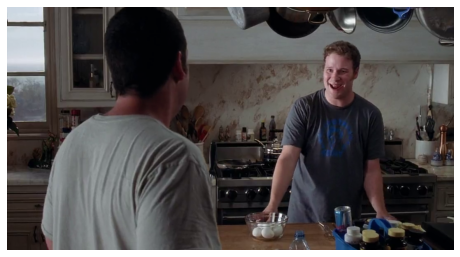

In [8]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[1][0])
plt.show()

In [9]:
print(data[0][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


In [10]:
print(data[0])

[array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)
 list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.306306

In [11]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

IMAGE_SIZE = 224

In [12]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

print(X.shape)
print(masks.shape)

(409, 224, 224, 3)
(409, 224, 224)


##### C. Split the data into train and test[400:9]. [1 Marks]



In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.022, random_state=42)


In [14]:
print(f"Shapes of Train & Test sets are: {X_train.shape},{X_test.shape}")

print(f"Shapes of Train & Test sets of Target are: {y_train.shape},{y_test.shape}")

Shapes of Train & Test sets are: (400, 224, 224, 3),(9, 224, 224, 3)
Shapes of Train & Test sets of Target are: (400, 224, 224),(9, 224, 224)


##### D. Select random image from the train data and display original image and masked image. [2 Marks]


In [15]:
choice = random.randint(0, len(X_train) - 1)
choice

68

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


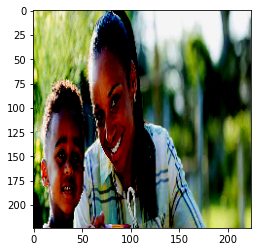

In [16]:
plt.imshow(X_train[choice])

Masked Image

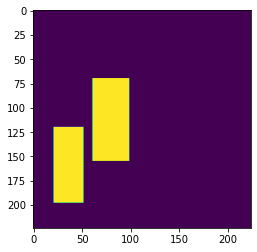

In [17]:
plt.imshow(y_train[choice])

#### 2. Model building [11 Marks]


##### A. Design a face mask detection model. [4 Marks]
 Hint: 1. Use MobileNet architecture for initial pre-trained non-trainable layers.
 
 Hint: 2. Add appropriate Upsampling layers to imitate U-net architecture.


In [18]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    #### Add your code here ####
    block1 = model.get_layer("conv_pw_1_relu").output ### Output shape of (112, 112, 32)   
    block2 = model.get_layer("conv_pw_3_relu").output ### Output shape of (56, 56, 128)
    block3 = model.get_layer("conv_pw_5_relu").output ### Output shape of (28, 28, 256)
    block4 = model.get_layer("conv_pw_11_relu").output ### Output shape of (14, 14, 512)
    block5 = model.get_layer("conv_pw_13_relu").output ### Output shape of (7, 7, 1024)

    x = Concatenate()([UpSampling2D()(block5), block4]) ### U-NET layer upsampling from (7, 7, 1024) to (14, 14, 1536)
    x = Concatenate()([UpSampling2D()(x), block3]) ### U-NET layer upsampling from (14, 14, 1536) to (28, 28, 1792)
    x = Concatenate()([UpSampling2D()(x), block2]) ### U-NET layer upsampling from (28, 28, 1792) to (56, 56, 1920)
    x = Concatenate()([UpSampling2D()(x), block1]) ### U-NET layer upsampling from (56, 56, 1920) to (112, 112, 198)
    x = UpSampling2D()(x) ### U-NET layer upsampling from (112, 112, 198) to (224, 224, 198)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs = x)

In [19]:
model = create_model(False)

In [20]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

##### B. Design your own Dice Coefficient and Loss function. [2 Marks]


In [21]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [22]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

##### C. Train and tune the model as required. [3 Marks]


In [23]:
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam as LegacyAdam
from tensorflow.keras.models import Model
import tensorflow as tf

# to define loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

In [24]:
adam = LegacyAdam(learning_rate = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, amsgrad = False)
model.compile(loss = loss, optimizer = "adam", metrics = [dice_coefficient])

In [25]:
import pydot

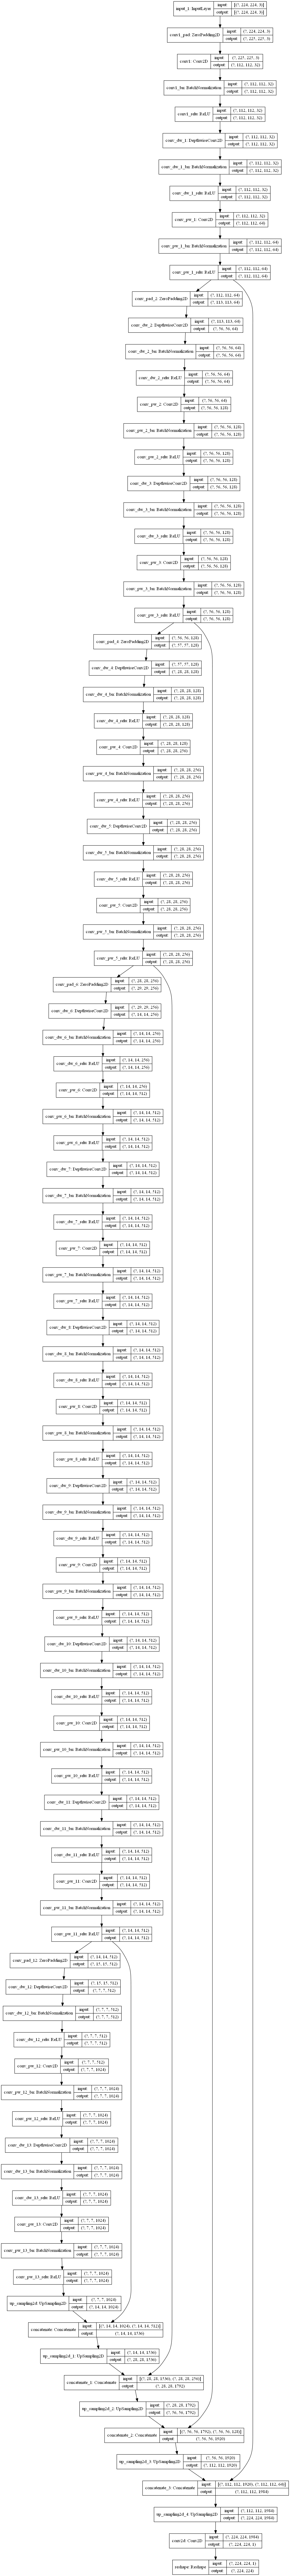

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [28]:
histroy_cnn = model.fit(X_test, y_test, epochs=10, batch_size=1, verbose=1, callbacks = [checkpoint, reduce_lr, stop], validation_split=0.15)

Epoch 1/10

Epoch 00001: loss improved from inf to 2.86113, saving model to model-2.86.h5
1/7 [===>..........................] - ETA: 0s - loss: 2.8611 - dice_coefficient: 0.1407
Epoch 00001: loss improved from 2.86113 to 2.32193, saving model to model-2.32.h5
2/7 [=======>......................] - ETA: 1s - loss: 2.3219 - dice_coefficient: 0.2311
Epoch 00001: loss improved from 2.32193 to 2.09958, saving model to model-2.10.h5
3/7 [===========>..................] - ETA: 1s - loss: 2.0996 - dice_coefficient: 0.2798
Epoch 00001: loss did not improve from 2.09958
4/7 [================>.............] - ETA: 1s - loss: 2.5503 - dice_coefficient: 0.2212
Epoch 00001: loss did not improve from 2.09958
5/7 [====================>.........] - ETA: 0s - loss: 2.8355 - dice_coefficient: 0.1819
Epoch 00001: loss did not improve from 2.09958
6/7 [========================>.....] - ETA: 0s - loss: 2.6502 - dice_coefficient: 0.2213
Epoch 00001: loss did not improve from 2.09958
7/7 [===================

##### D. Evaluate and share insights on performance of the model. [2 Marks]


Text(0.5, 1.0, 'Training and validation loss')

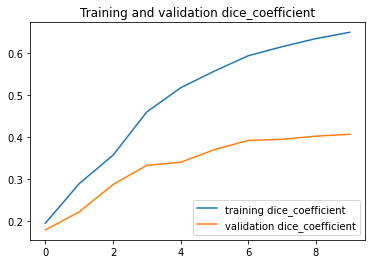

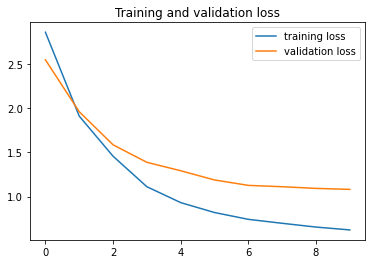

In [29]:
## Accuracy and Loss plots

dice_coefficient_cnn      = histroy_cnn.history['dice_coefficient']
val_dice_coefficient_cnn  = histroy_cnn.history['val_dice_coefficient']
loss_cnn     = histroy_cnn.history['loss']
val_loss_cnn = histroy_cnn.history['val_loss']

epochs   = range(len(dice_coefficient_cnn))
dice_coefficient_cnn
plt.plot  (epochs, dice_coefficient_cnn, label = 'training dice_coefficient')
plt.plot  (epochs, val_dice_coefficient_cnn, label = 'validation dice_coefficient')
plt.title ('Training and validation dice_coefficient')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss_cnn, label = 'training loss')
plt.plot  (epochs, val_loss_cnn, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

We could observe that at Epoch = 10, 

we are seeing maximum test dice coefficient of 0.41 and train dice coefficient of 0.65. Loss also decrease with increase in number of Epoch.

#### 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image. [2 Marks]

In [30]:
preds_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 2ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


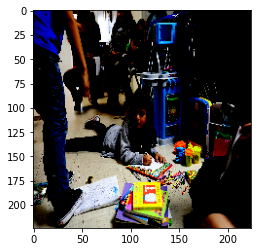

In [31]:
# For a sample image
plt.imshow(X_test[3])

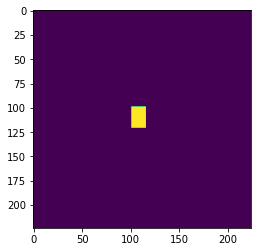

In [32]:
plt.imshow(y_test[3])

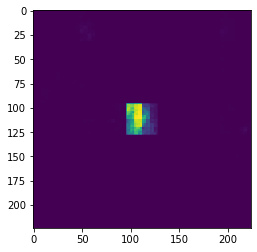

In [33]:
plt.imshow(preds_test[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


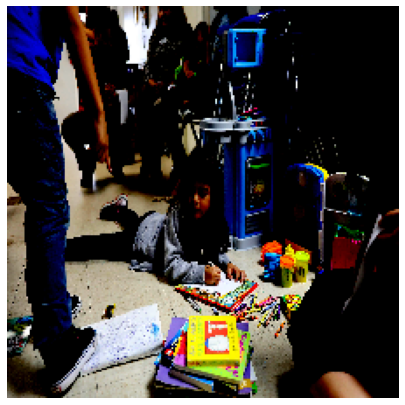

In [34]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_test[3])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

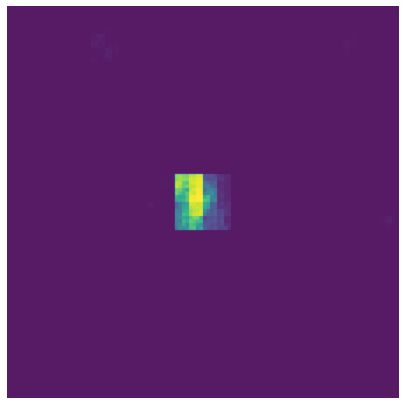

In [35]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(preds_test[3], alpha = 0.9)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

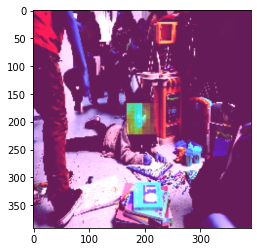

In [36]:
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)
cv2.imshow('Image', img)
plt.imshow(img)

# Part B - 10 Marks

**• DOMAIN:** Entertainment

**• CONTEXT:** Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

The data labelling is already done. Since there higher time complexity is involved.

**• DATA DESCRIPTION:** The dataset comprises of face images.

**• PROJECT OBJECTIVE:** To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

### Steps and tasks: [ Total Score: 10 Marks]

#### 1. Read/import images from folder ‘training_images’. [2 Marks]

In [37]:
images_folder = "training_images-20211126T092819Z-001.zip"

In [38]:
from zipfile import ZipFile
with ZipFile(images_folder,'r') as zip:
  zip.extractall()

In [39]:
import glob

# specify the train folder
train_folder = "training_images"

# get a list of all the image files in the train folder
image_files = glob.glob(train_folder + "/*.jpg")


In [40]:
len(image_files)

1091

In [41]:
image_files[0]

'training_images\\real_00001.jpg'

#### 2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images. [3 Marks]
Hint: You can use ’haarcascade_frontalface_default.xml’ from internet to detect faces which is available open source.

In [42]:
import cv2
import os

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

for filename in os.listdir('training_images'):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img = cv2.imread(os.path.join('training_images', filename))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
        # Save the image with the detected faces to the new folder
        cv2.imwrite('faces_detected/' + filename, img)


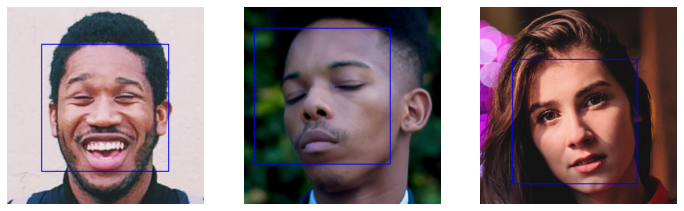

In [43]:
# Set path to the images folder
path = 'faces_detected/'

# Load the images from the folder
images = []
for image_name in os.listdir(path):
    if image_name.endswith('.jpg') or image_name.endswith('.png'):
        images.append(plt.imread(os.path.join(path, image_name)))

# Set the number of random images to display
num_images = 3

# Select random images from the folder
selected_images = random.sample(images, num_images)

# Display the selected images using matplotlib.pyplot
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(12, 4))

for i in range(num_images):
    axes[i].imshow(selected_images[i])
    axes[i].axis('off')

# Show the images
plt.show()

#### 3. From the same loop above, extract metadata of the faces and write into a DataFrame. [3 Marks]

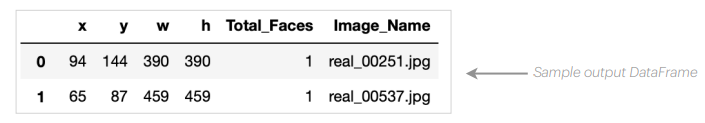

In [44]:
import cv2
import os
import pandas as pd

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

metadata = []
for filename in os.listdir('training_images'):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img = cv2.imread(os.path.join('training_images', filename))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        for (x, y, w, h) in faces:
            face = img[y:y+h, x:x+w]
            metadata.append({
                'x': x,
                'y': y,
                'w': w,
                'h': h,
                'Total_Faces': len(faces),
                'Image_Name': filename
            })
    
df = pd.DataFrame(metadata)


In [45]:
df.head()

x    y    w    h  Total_Faces      Image_Name
0  146  140  428  428            1  real_00001.jpg
1   80  140  436  436            1  real_00002.jpg
2   33  121  362  362            1  real_00003.jpg
3  134  173  356  356            3  real_00004.jpg
4   91   28   90   90            3  real_00004.jpg

#### 4. Save the output Dataframe in .csv format. [2 Marks]

In [46]:
#Saving the output of Dataframe df in csv format
df.to_csv('face_metadata.csv', index=False)

# Part C - 30 Marks

**• DOMAIN:** Face Recognition

**• CONTEXT:** Company X intends to build a face identification model to recognise human faces.

**• DATA DESCRIPTION:** The dataset comprises of images and its mask where there is a human face.

**• PROJECT OBJECTIVE:** Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library. Some data samples:

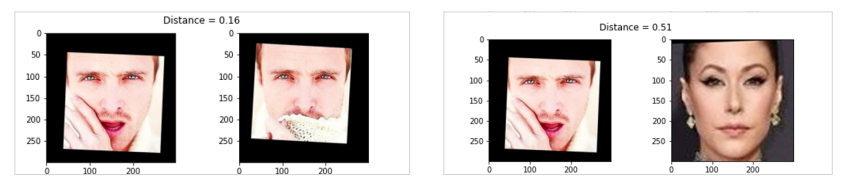

### Steps and tasks: [ Total Score: 30 Marks]

#### 1. Unzip, read and Load data(‘PINS.zip’) into session. [2 Marks]


In [47]:
pins_folder = 'PINS.zip'

In [48]:
from zipfile import ZipFile
with ZipFile(pins_folder,'r') as zip:
  zip.extractall()

In [49]:
import glob

# specify the train folder
pins_folder = "PINS"

# get a list of all the image files in the train folder
image_files_pins = glob.glob(pins_folder + "/*/*.jpg")


In [50]:
len(image_files_pins)

10770

In [51]:
image_files_pins[0]

'PINS\\pins_Aaron Paul\\Aaron Paul0_262.jpg'

#### 2. Write function to create metadata of the image. [4 Marks]
Hint: Metadata means derived information from the available data which can be useful for particular problem statement.


In [52]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    

In [53]:
IdentityMetadata('PINS', 'pins_Aaron Paul', 'Aaron Paul0_262.jpg')

PINS pins_Aaron Paul Aaron Paul0_262.jpg


PINS\pins_Aaron Paul\Aaron Paul0_262.jpg

In [54]:
z = IdentityMetadata('PINS', 'pins_Aaron Paul', 'Aaron Paul0_262.jpg')

PINS pins_Aaron Paul Aaron Paul0_262.jpg


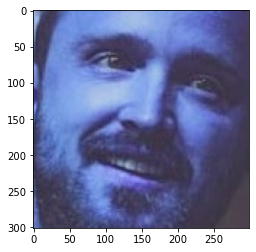

In [55]:
test_metadata = cv2.imread(str(z))
plt.imshow(test_metadata)

#### 3. Write a loop to iterate through each and every image and create metadata for all the images. [4 Marks]


In [56]:
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [57]:
# Call load_metadata to read the images and assign metadata to a variable

metadata = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

PINS pins_Aaron Paul Aaron Paul0_262.jpg
PINS pins_Aaron Paul Aaron Paul101_247.jpg
PINS pins_Aaron Paul Aaron Paul101_248.jpg
PINS pins_Aaron Paul Aaron Paul101_249.jpg
PINS pins_Aaron Paul Aaron Paul103_217.jpg
PINS pins_Aaron Paul Aaron Paul113_228.jpg
PINS pins_Aaron Paul Aaron Paul114_271.jpg
PINS pins_Aaron Paul Aaron Paul116_240.jpg
PINS pins_Aaron Paul Aaron Paul117_213.jpg
PINS pins_Aaron Paul Aaron Paul119_219.jpg
PINS pins_Aaron Paul Aaron Paul120_290.jpg
PINS pins_Aaron Paul Aaron Paul124_221.jpg
PINS pins_Aaron Paul Aaron Paul126_291.jpg
PINS pins_Aaron Paul Aaron Paul129_259.jpg
PINS pins_Aaron Paul Aaron Paul129_260.jpg
PINS pins_Aaron Paul Aaron Paul130_215.jpg
PINS pins_Aaron Paul Aaron Paul132_236.jpg
PINS pins_Aaron Paul Aaron Paul136_225.jpg
PINS pins_Aaron Paul Aaron Paul137_250.jpg
PINS pins_Aaron Paul Aaron Paul138_233.jpg
PINS pins_Aaron Paul Aaron Paul140_243.jpg
PINS pins_Aaron Paul Aaron Paul145_256.jpg
PINS pins_Aaron Paul Aaron Paul155_220.jpg
PINS pins_Aar

PINS pins_Amanda Crew Amanda Crew107.jpg
PINS pins_Amanda Crew Amanda Crew108.jpg
PINS pins_Amanda Crew Amanda Crew109.jpg
PINS pins_Amanda Crew Amanda Crew11.jpg
PINS pins_Amanda Crew Amanda Crew110.jpg
PINS pins_Amanda Crew Amanda Crew113.jpg
PINS pins_Amanda Crew Amanda Crew114.jpg
PINS pins_Amanda Crew Amanda Crew115.jpg
PINS pins_Amanda Crew Amanda Crew116.jpg
PINS pins_Amanda Crew Amanda Crew117.jpg
PINS pins_Amanda Crew Amanda Crew118.jpg
PINS pins_Amanda Crew Amanda Crew119.jpg
PINS pins_Amanda Crew Amanda Crew12.jpg
PINS pins_Amanda Crew Amanda Crew120.jpg
PINS pins_Amanda Crew Amanda Crew121.jpg
PINS pins_Amanda Crew Amanda Crew122.jpg
PINS pins_Amanda Crew Amanda Crew13.jpg
PINS pins_Amanda Crew Amanda Crew15.jpg
PINS pins_Amanda Crew Amanda Crew16.jpg
PINS pins_Amanda Crew Amanda Crew17.jpg
PINS pins_Amanda Crew Amanda Crew18.jpg
PINS pins_Amanda Crew Amanda Crew19.jpg
PINS pins_Amanda Crew Amanda Crew2.jpg
PINS pins_Amanda Crew Amanda Crew20.jpg
PINS pins_Amanda Crew Amand

PINS pins_anne hathaway anne hathaway16.jpg
PINS pins_anne hathaway anne hathaway17.jpg
PINS pins_anne hathaway anne hathaway18.jpg
PINS pins_anne hathaway anne hathaway19.jpg
PINS pins_anne hathaway anne hathaway2.jpg
PINS pins_anne hathaway anne hathaway20.jpg
PINS pins_anne hathaway anne hathaway21.jpg
PINS pins_anne hathaway anne hathaway22.jpg
PINS pins_anne hathaway anne hathaway23.jpg
PINS pins_anne hathaway anne hathaway24.jpg
PINS pins_anne hathaway anne hathaway25.jpg
PINS pins_anne hathaway anne hathaway26.jpg
PINS pins_anne hathaway anne hathaway27.jpg
PINS pins_anne hathaway anne hathaway28.jpg
PINS pins_anne hathaway anne hathaway29.jpg
PINS pins_anne hathaway anne hathaway3.jpg
PINS pins_anne hathaway anne hathaway30.jpg
PINS pins_anne hathaway anne hathaway31.jpg
PINS pins_anne hathaway anne hathaway32.jpg
PINS pins_anne hathaway anne hathaway33.jpg
PINS pins_anne hathaway anne hathaway34.jpg
PINS pins_anne hathaway anne hathaway35.jpg
PINS pins_anne hathaway anne hatha

PINS pins_Betsy Brandt Betsy Brandt103_428.jpg
PINS pins_Betsy Brandt Betsy Brandt105_400.jpg
PINS pins_Betsy Brandt Betsy Brandt107_385.jpg
PINS pins_Betsy Brandt Betsy Brandt108_377.jpg
PINS pins_Betsy Brandt Betsy Brandt116_429.jpg
PINS pins_Betsy Brandt Betsy Brandt11_394.jpg
PINS pins_Betsy Brandt Betsy Brandt122_416.jpg
PINS pins_Betsy Brandt Betsy Brandt125_430.jpg
PINS pins_Betsy Brandt Betsy Brandt126_389.jpg
PINS pins_Betsy Brandt Betsy Brandt130_423.jpg
PINS pins_Betsy Brandt Betsy Brandt135_425.jpg
PINS pins_Betsy Brandt Betsy Brandt136_412.jpg
PINS pins_Betsy Brandt Betsy Brandt140_408.jpg
PINS pins_Betsy Brandt Betsy Brandt141_402.jpg
PINS pins_Betsy Brandt Betsy Brandt142_388.jpg
PINS pins_Betsy Brandt Betsy Brandt144_393.jpg
PINS pins_Betsy Brandt Betsy Brandt147_418.jpg
PINS pins_Betsy Brandt Betsy Brandt148_379.jpg
PINS pins_Betsy Brandt Betsy Brandt14_433.jpg
PINS pins_Betsy Brandt Betsy Brandt150_442.jpg
PINS pins_Betsy Brandt Betsy Brandt151_399.jpg
PINS pins_Betsy

PINS pins_brie larson brie larson81.jpg
PINS pins_brie larson brie larson82.jpg
PINS pins_brie larson brie larson84.jpg
PINS pins_brie larson brie larson85.jpg
PINS pins_brie larson brie larson86.jpg
PINS pins_brie larson brie larson87.jpg
PINS pins_brie larson brie larson88.jpg
PINS pins_brie larson brie larson89.jpg
PINS pins_brie larson brie larson9.jpg
PINS pins_brie larson brie larson90.jpg
PINS pins_brie larson brie larson91.jpg
PINS pins_brie larson brie larson92.jpg
PINS pins_brie larson brie larson93.jpg
PINS pins_brie larson brie larson94.jpg
PINS pins_brie larson brie larson95.jpg
PINS pins_brie larson brie larson96.jpg
PINS pins_brie larson brie larson97.jpg
PINS pins_brie larson brie larson98.jpg
PINS pins_brie larson brie larson99.jpg
PINS pins_Brit Marling Brit Marling100_549.jpg
PINS pins_Brit Marling Brit Marling103_548.jpg
PINS pins_Brit Marling Brit Marling104_452.jpg
PINS pins_Brit Marling Brit Marling106_493.jpg
PINS pins_Brit Marling Brit Marling10_492.jpg
PINS pi

PINS pins_Cameron Monaghan Cameron Monaghan76.jpg
PINS pins_Cameron Monaghan Cameron Monaghan77.jpg
PINS pins_Cameron Monaghan Cameron Monaghan78.jpg
PINS pins_Cameron Monaghan Cameron Monaghan79.jpg
PINS pins_Cameron Monaghan Cameron Monaghan8.jpg
PINS pins_Cameron Monaghan Cameron Monaghan80.jpg
PINS pins_Cameron Monaghan Cameron Monaghan81.jpg
PINS pins_Cameron Monaghan Cameron Monaghan82.jpg
PINS pins_Cameron Monaghan Cameron Monaghan83.jpg
PINS pins_Cameron Monaghan Cameron Monaghan84.jpg
PINS pins_Cameron Monaghan Cameron Monaghan85.jpg
PINS pins_Cameron Monaghan Cameron Monaghan86.jpg
PINS pins_Cameron Monaghan Cameron Monaghan87.jpg
PINS pins_Cameron Monaghan Cameron Monaghan88.jpg
PINS pins_Cameron Monaghan Cameron Monaghan89.jpg
PINS pins_Cameron Monaghan Cameron Monaghan9.jpg
PINS pins_Cameron Monaghan Cameron Monaghan90.jpg
PINS pins_Cameron Monaghan Cameron Monaghan91.jpg
PINS pins_Cameron Monaghan Cameron Monaghan92.jpg
PINS pins_Cameron Monaghan Cameron Monaghan93.jpg
PI

PINS pins_Cobie Smulders Cobie Smulders0.jpg
PINS pins_Cobie Smulders Cobie Smulders1.jpg
PINS pins_Cobie Smulders Cobie Smulders10.jpg
PINS pins_Cobie Smulders Cobie Smulders100.jpg
PINS pins_Cobie Smulders Cobie Smulders101.jpg
PINS pins_Cobie Smulders Cobie Smulders102.jpg
PINS pins_Cobie Smulders Cobie Smulders103.jpg
PINS pins_Cobie Smulders Cobie Smulders104.jpg
PINS pins_Cobie Smulders Cobie Smulders105.jpg
PINS pins_Cobie Smulders Cobie Smulders106.jpg
PINS pins_Cobie Smulders Cobie Smulders107.jpg
PINS pins_Cobie Smulders Cobie Smulders108.jpg
PINS pins_Cobie Smulders Cobie Smulders109.jpg
PINS pins_Cobie Smulders Cobie Smulders11.jpg
PINS pins_Cobie Smulders Cobie Smulders110.jpg
PINS pins_Cobie Smulders Cobie Smulders111.jpg
PINS pins_Cobie Smulders Cobie Smulders112.jpg
PINS pins_Cobie Smulders Cobie Smulders113.jpg
PINS pins_Cobie Smulders Cobie Smulders114.jpg
PINS pins_Cobie Smulders Cobie Smulders115.jpg
PINS pins_Cobie Smulders Cobie Smulders116.jpg
PINS pins_Cobie Smu

PINS pins_Dominic Purcell Dominic Purcell104.jpg
PINS pins_Dominic Purcell Dominic Purcell105.jpg
PINS pins_Dominic Purcell Dominic Purcell106.jpg
PINS pins_Dominic Purcell Dominic Purcell107.jpg
PINS pins_Dominic Purcell Dominic Purcell108.jpg
PINS pins_Dominic Purcell Dominic Purcell11.jpg
PINS pins_Dominic Purcell Dominic Purcell12.jpg
PINS pins_Dominic Purcell Dominic Purcell13.jpg
PINS pins_Dominic Purcell Dominic Purcell14.jpg
PINS pins_Dominic Purcell Dominic Purcell15.jpg
PINS pins_Dominic Purcell Dominic Purcell16.jpg
PINS pins_Dominic Purcell Dominic Purcell17.jpg
PINS pins_Dominic Purcell Dominic Purcell18.jpg
PINS pins_Dominic Purcell Dominic Purcell19.jpg
PINS pins_Dominic Purcell Dominic Purcell2.jpg
PINS pins_Dominic Purcell Dominic Purcell20.jpg
PINS pins_Dominic Purcell Dominic Purcell21.jpg
PINS pins_Dominic Purcell Dominic Purcell22.jpg
PINS pins_Dominic Purcell Dominic Purcell23.jpg
PINS pins_Dominic Purcell Dominic Purcell24.jpg
PINS pins_Dominic Purcell Dominic Pu

PINS pins_eliza taylor eliza taylor96.jpg
PINS pins_eliza taylor eliza taylor97.jpg
PINS pins_eliza taylor eliza taylor98.jpg
PINS pins_eliza taylor eliza taylor99.jpg
PINS pins_elizabeth olsen face elizabeth olsen face0.jpg
PINS pins_elizabeth olsen face elizabeth olsen face1.jpg
PINS pins_elizabeth olsen face elizabeth olsen face10.jpg
PINS pins_elizabeth olsen face elizabeth olsen face100.jpg
PINS pins_elizabeth olsen face elizabeth olsen face101.jpg
PINS pins_elizabeth olsen face elizabeth olsen face102.jpg
PINS pins_elizabeth olsen face elizabeth olsen face103.jpg
PINS pins_elizabeth olsen face elizabeth olsen face104.jpg
PINS pins_elizabeth olsen face elizabeth olsen face106.jpg
PINS pins_elizabeth olsen face elizabeth olsen face107.jpg
PINS pins_elizabeth olsen face elizabeth olsen face108.jpg
PINS pins_elizabeth olsen face elizabeth olsen face109.jpg
PINS pins_elizabeth olsen face elizabeth olsen face11.jpg
PINS pins_elizabeth olsen face elizabeth olsen face110.jpg
PINS pins_el

PINS pins_Emily Bett Rickards Emily Bett Rickards49.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards5.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards50.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards51.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards52.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards53.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards54.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards55.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards56.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards57.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards58.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards59.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards6.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards60.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards61.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards62.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards63.jpg
PINS pins_Emily Bett Rickards Emily Bett Rickards6

PINS pins_gal gadot face gal gadot face80.jpg
PINS pins_gal gadot face gal gadot face81.jpg
PINS pins_gal gadot face gal gadot face82.jpg
PINS pins_gal gadot face gal gadot face83.jpg
PINS pins_gal gadot face gal gadot face84.jpg
PINS pins_gal gadot face gal gadot face85.jpg
PINS pins_gal gadot face gal gadot face86.jpg
PINS pins_gal gadot face gal gadot face87.jpg
PINS pins_gal gadot face gal gadot face88.jpg
PINS pins_gal gadot face gal gadot face89.jpg
PINS pins_gal gadot face gal gadot face9.jpg
PINS pins_gal gadot face gal gadot face90.jpg
PINS pins_gal gadot face gal gadot face91.jpg
PINS pins_gal gadot face gal gadot face92.jpg
PINS pins_gal gadot face gal gadot face93.jpg
PINS pins_gal gadot face gal gadot face94.jpg
PINS pins_gal gadot face gal gadot face95.jpg
PINS pins_gal gadot face gal gadot face96.jpg
PINS pins_gal gadot face gal gadot face97.jpg
PINS pins_gal gadot face gal gadot face98.jpg
PINS pins_gal gadot face gal gadot face99.jpg
PINS pins_grant gustin face grant g

PINS pins_jason isaacs jason isaacs129_2116.jpg
PINS pins_jason isaacs jason isaacs130_2068.jpg
PINS pins_jason isaacs jason isaacs131_2099.jpg
PINS pins_jason isaacs jason isaacs132_2034.jpg
PINS pins_jason isaacs jason isaacs133_2083.jpg
PINS pins_jason isaacs jason isaacs134_2101.jpg
PINS pins_jason isaacs jason isaacs135_2133.jpg
PINS pins_jason isaacs jason isaacs136_2018.jpg
PINS pins_jason isaacs jason isaacs13_2126.jpg
PINS pins_jason isaacs jason isaacs142_2023.jpg
PINS pins_jason isaacs jason isaacs143_2044.jpg
PINS pins_jason isaacs jason isaacs144_2051.jpg
PINS pins_jason isaacs jason isaacs146_2094.jpg
PINS pins_jason isaacs jason isaacs147_2117.jpg
PINS pins_jason isaacs jason isaacs14_2053.jpg
PINS pins_jason isaacs jason isaacs150_2009.jpg
PINS pins_jason isaacs jason isaacs153_2132.jpg
PINS pins_jason isaacs jason isaacs156_2025.jpg
PINS pins_jason isaacs jason isaacs157_2014.jpg
PINS pins_jason isaacs jason isaacs158_2048.jpg
PINS pins_jason isaacs jason isaacs159_209

PINS pins_Jesse Eisenberg Jesse Eisenberg100_1351.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg103_1422.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg106_1419.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg111_1360.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg112_1387.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg113_1388.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg118_1386.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg119_1377.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg120_1418.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg125_1352.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg128_1414.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg129_1399.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg12_1345.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg12_1346.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg12_1347.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg134_1361.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg13_1410.jpg
PINS pins_Jesse Eisenberg Jesse Eisenberg13_1411.jpg
PINS pins_Jesse Eisenberg Jesse E

PINS pins_kiernan shipka kiernan shipka 45.jpg
PINS pins_kiernan shipka kiernan shipka 46.jpg
PINS pins_kiernan shipka kiernan shipka 47.jpg
PINS pins_kiernan shipka kiernan shipka 48.jpg
PINS pins_kiernan shipka kiernan shipka 49.jpg
PINS pins_kiernan shipka kiernan shipka 5.jpg
PINS pins_kiernan shipka kiernan shipka 50.jpg
PINS pins_kiernan shipka kiernan shipka 51.jpg
PINS pins_kiernan shipka kiernan shipka 52.jpg
PINS pins_kiernan shipka kiernan shipka 53.jpg
PINS pins_kiernan shipka kiernan shipka 54.jpg
PINS pins_kiernan shipka kiernan shipka 55.jpg
PINS pins_kiernan shipka kiernan shipka 56.jpg
PINS pins_kiernan shipka kiernan shipka 57.jpg
PINS pins_kiernan shipka kiernan shipka 58.jpg
PINS pins_kiernan shipka kiernan shipka 59.jpg
PINS pins_kiernan shipka kiernan shipka 6.jpg
PINS pins_kiernan shipka kiernan shipka 60.jpg
PINS pins_kiernan shipka kiernan shipka 61.jpg
PINS pins_kiernan shipka kiernan shipka 62.jpg
PINS pins_kiernan shipka kiernan shipka 63.jpg
PINS pins_kiern

PINS pins_Kumail Nanjiani Kumail Nanjiani63.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani64.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani65.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani66.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani67.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani68.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani69.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani7.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani70.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani71.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani72.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani73.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani74.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani75.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani76.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani77.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani78.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani79.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani8.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani80.jpg
PINS pins_Kumail Nanjiani Kumail Nanjiani8

PINS pins_maria pedraza maria pedraza108_1614.jpg
PINS pins_maria pedraza maria pedraza11_1579.jpg
PINS pins_maria pedraza maria pedraza121_1623.jpg
PINS pins_maria pedraza maria pedraza123_1583.jpg
PINS pins_maria pedraza maria pedraza124_1598.jpg
PINS pins_maria pedraza maria pedraza128_1563.jpg
PINS pins_maria pedraza maria pedraza129_1605.jpg
PINS pins_maria pedraza maria pedraza130_1567.jpg
PINS pins_maria pedraza maria pedraza133_1621.jpg
PINS pins_maria pedraza maria pedraza135_1606.jpg
PINS pins_maria pedraza maria pedraza137_1588.jpg
PINS pins_maria pedraza maria pedraza137_1589.jpg
PINS pins_maria pedraza maria pedraza141_1615.jpg
PINS pins_maria pedraza maria pedraza143_1593.jpg
PINS pins_maria pedraza maria pedraza146_1584.jpg
PINS pins_maria pedraza maria pedraza152_1564.jpg
PINS pins_maria pedraza maria pedraza154_1577.jpg
PINS pins_maria pedraza maria pedraza156_1630.jpg
PINS pins_maria pedraza maria pedraza157_1604.jpg
PINS pins_maria pedraza maria pedraza158_1573.jpg
P

PINS pins_miguel herran miguel herran45_369.jpg
PINS pins_miguel herran miguel herran47_327.jpg
PINS pins_miguel herran miguel herran49_340.jpg
PINS pins_miguel herran miguel herran4_342.jpg
PINS pins_miguel herran miguel herran51_326.jpg
PINS pins_miguel herran miguel herran52_318.jpg
PINS pins_miguel herran miguel herran59_363.jpg
PINS pins_miguel herran miguel herran60_362.jpg
PINS pins_miguel herran miguel herran62_334.jpg
PINS pins_miguel herran miguel herran64_298.jpg
PINS pins_miguel herran miguel herran68_307.jpg
PINS pins_miguel herran miguel herran69_331.jpg
PINS pins_miguel herran miguel herran6_315.jpg
PINS pins_miguel herran miguel herran71_337.jpg
PINS pins_miguel herran miguel herran77_297.jpg
PINS pins_miguel herran miguel herran78_375.jpg
PINS pins_miguel herran miguel herran7_359.jpg
PINS pins_miguel herran miguel herran83_321.jpg
PINS pins_miguel herran miguel herran84_317.jpg
PINS pins_miguel herran miguel herran85_370.jpg
PINS pins_miguel herran miguel herran86_357

PINS pins_Morgan Freeman Morgan Freeman92_570.jpg
PINS pins_Morgan Freeman Morgan Freeman95_588.jpg
PINS pins_Morgan Freeman Morgan Freeman98_636.jpg
PINS pins_Morgan Freeman Morgan Freeman99_606.jpg
PINS pins_Natalie Portman Natalie Portman 0.jpg
PINS pins_Natalie Portman Natalie Portman 1.jpg
PINS pins_Natalie Portman Natalie Portman 10.jpg
PINS pins_Natalie Portman Natalie Portman 100.jpg
PINS pins_Natalie Portman Natalie Portman 101.jpg
PINS pins_Natalie Portman Natalie Portman 102.jpg
PINS pins_Natalie Portman Natalie Portman 103.jpg
PINS pins_Natalie Portman Natalie Portman 104.jpg
PINS pins_Natalie Portman Natalie Portman 105.jpg
PINS pins_Natalie Portman Natalie Portman 106.jpg
PINS pins_Natalie Portman Natalie Portman 107.jpg
PINS pins_Natalie Portman Natalie Portman 108.jpg
PINS pins_Natalie Portman Natalie Portman 109.jpg
PINS pins_Natalie Portman Natalie Portman 11.jpg
PINS pins_Natalie Portman Natalie Portman 110.jpg
PINS pins_Natalie Portman Natalie Portman 111.jpg
PINS p

PINS pins_Peter Dinklage Peter Dinklage199_144.jpg
PINS pins_Peter Dinklage Peter Dinklage19_175.jpg
PINS pins_Peter Dinklage Peter Dinklage1_119.jpg
PINS pins_Peter Dinklage Peter Dinklage20_155.jpg
PINS pins_Peter Dinklage Peter Dinklage23_158.jpg
PINS pins_Peter Dinklage Peter Dinklage26_205.jpg
PINS pins_Peter Dinklage Peter Dinklage28_146.jpg
PINS pins_Peter Dinklage Peter Dinklage29_132.jpg
PINS pins_Peter Dinklage Peter Dinklage2_185.jpg
PINS pins_Peter Dinklage Peter Dinklage30_138.jpg
PINS pins_Peter Dinklage Peter Dinklage31_162.jpg
PINS pins_Peter Dinklage Peter Dinklage34_203.jpg
PINS pins_Peter Dinklage Peter Dinklage35_150.jpg
PINS pins_Peter Dinklage Peter Dinklage36_118.jpg
PINS pins_Peter Dinklage Peter Dinklage37_170.jpg
PINS pins_Peter Dinklage Peter Dinklage40_165.jpg
PINS pins_Peter Dinklage Peter Dinklage42_160.jpg
PINS pins_Peter Dinklage Peter Dinklage44_163.jpg
PINS pins_Peter Dinklage Peter Dinklage45_191.jpg
PINS pins_Peter Dinklage Peter Dinklage46_190.jpg
P

PINS pins_Robert Knepper Robert Knepper0.jpg
PINS pins_Robert Knepper Robert Knepper1.jpg
PINS pins_Robert Knepper Robert Knepper10.jpg
PINS pins_Robert Knepper Robert Knepper11.jpg
PINS pins_Robert Knepper Robert Knepper12.jpg
PINS pins_Robert Knepper Robert Knepper13.jpg
PINS pins_Robert Knepper Robert Knepper14.jpg
PINS pins_Robert Knepper Robert Knepper15.jpg
PINS pins_Robert Knepper Robert Knepper16.jpg
PINS pins_Robert Knepper Robert Knepper17.jpg
PINS pins_Robert Knepper Robert Knepper18.jpg
PINS pins_Robert Knepper Robert Knepper19.jpg
PINS pins_Robert Knepper Robert Knepper2.jpg
PINS pins_Robert Knepper Robert Knepper20.jpg
PINS pins_Robert Knepper Robert Knepper21.jpg
PINS pins_Robert Knepper Robert Knepper22.jpg
PINS pins_Robert Knepper Robert Knepper23.jpg
PINS pins_Robert Knepper Robert Knepper24.jpg
PINS pins_Robert Knepper Robert Knepper25.jpg
PINS pins_Robert Knepper Robert Knepper26.jpg
PINS pins_Robert Knepper Robert Knepper27.jpg
PINS pins_Robert Knepper Robert Knepp

PINS pins_Scarlett Johansson Scarlett Johansson23.jpg
PINS pins_Scarlett Johansson Scarlett Johansson24.jpg
PINS pins_Scarlett Johansson Scarlett Johansson25.jpg
PINS pins_Scarlett Johansson Scarlett Johansson26.jpg
PINS pins_Scarlett Johansson Scarlett Johansson27.jpg
PINS pins_Scarlett Johansson Scarlett Johansson28.jpg
PINS pins_Scarlett Johansson Scarlett Johansson29.jpg
PINS pins_Scarlett Johansson Scarlett Johansson3.jpg
PINS pins_Scarlett Johansson Scarlett Johansson30.jpg
PINS pins_Scarlett Johansson Scarlett Johansson31.jpg
PINS pins_Scarlett Johansson Scarlett Johansson32.jpg
PINS pins_Scarlett Johansson Scarlett Johansson33.jpg
PINS pins_Scarlett Johansson Scarlett Johansson34.jpg
PINS pins_Scarlett Johansson Scarlett Johansson35.jpg
PINS pins_Scarlett Johansson Scarlett Johansson36.jpg
PINS pins_Scarlett Johansson Scarlett Johansson37.jpg
PINS pins_Scarlett Johansson Scarlett Johansson38.jpg
PINS pins_Scarlett Johansson Scarlett Johansson39.jpg
PINS pins_Scarlett Johansson 

PINS pins_Sophie Turner Sophie Turner0_1665.jpg
PINS pins_Sophie Turner Sophie Turner100_1636.jpg
PINS pins_Sophie Turner Sophie Turner101_1739.jpg
PINS pins_Sophie Turner Sophie Turner102_1693.jpg
PINS pins_Sophie Turner Sophie Turner104_1637.jpg
PINS pins_Sophie Turner Sophie Turner105_1731.jpg
PINS pins_Sophie Turner Sophie Turner107_1680.jpg
PINS pins_Sophie Turner Sophie Turner108_1674.jpg
PINS pins_Sophie Turner Sophie Turner10_1711.jpg
PINS pins_Sophie Turner Sophie Turner110_1634.jpg
PINS pins_Sophie Turner Sophie Turner111_1716.jpg
PINS pins_Sophie Turner Sophie Turner117_1656.jpg
PINS pins_Sophie Turner Sophie Turner118_1655.jpg
PINS pins_Sophie Turner Sophie Turner119_1706.jpg
PINS pins_Sophie Turner Sophie Turner121_1735.jpg
PINS pins_Sophie Turner Sophie Turner122_1740.jpg
PINS pins_Sophie Turner Sophie Turner126_1689.jpg
PINS pins_Sophie Turner Sophie Turner127_1714.jpg
PINS pins_Sophie Turner Sophie Turner12_1672.jpg
PINS pins_Sophie Turner Sophie Turner131_1663.jpg
PINS

PINS pins_taylor swift taylor swift49.jpg
PINS pins_taylor swift taylor swift5.jpg
PINS pins_taylor swift taylor swift50.jpg
PINS pins_taylor swift taylor swift51.jpg
PINS pins_taylor swift taylor swift52.jpg
PINS pins_taylor swift taylor swift53.jpg
PINS pins_taylor swift taylor swift54.jpg
PINS pins_taylor swift taylor swift55.jpg
PINS pins_taylor swift taylor swift56.jpg
PINS pins_taylor swift taylor swift57.jpg
PINS pins_taylor swift taylor swift58.jpg
PINS pins_taylor swift taylor swift59.jpg
PINS pins_taylor swift taylor swift6.jpg
PINS pins_taylor swift taylor swift60.jpg
PINS pins_taylor swift taylor swift61.jpg
PINS pins_taylor swift taylor swift62.jpg
PINS pins_taylor swift taylor swift63.jpg
PINS pins_taylor swift taylor swift64.jpg
PINS pins_taylor swift taylor swift65.jpg
PINS pins_taylor swift taylor swift66.jpg
PINS pins_taylor swift taylor swift67.jpg
PINS pins_taylor swift taylor swift68.jpg
PINS pins_taylor swift taylor swift69.jpg
PINS pins_taylor swift taylor swift7

PINS pins_Ursula Corbero Ursula Corbero101_2348.jpg
PINS pins_Ursula Corbero Ursula Corbero104_2353.jpg
PINS pins_Ursula Corbero Ursula Corbero107_2390.jpg
PINS pins_Ursula Corbero Ursula Corbero108_2360.jpg
PINS pins_Ursula Corbero Ursula Corbero109_2379.jpg
PINS pins_Ursula Corbero Ursula Corbero10_2397.jpg
PINS pins_Ursula Corbero Ursula Corbero110_2333.jpg
PINS pins_Ursula Corbero Ursula Corbero112_2389.jpg
PINS pins_Ursula Corbero Ursula Corbero116_2340.jpg
PINS pins_Ursula Corbero Ursula Corbero117_2368.jpg
PINS pins_Ursula Corbero Ursula Corbero119_2361.jpg
PINS pins_Ursula Corbero Ursula Corbero11_2347.jpg
PINS pins_Ursula Corbero Ursula Corbero121_2372.jpg
PINS pins_Ursula Corbero Ursula Corbero126_2387.jpg
PINS pins_Ursula Corbero Ursula Corbero133_2409.jpg
PINS pins_Ursula Corbero Ursula Corbero134_2395.jpg
PINS pins_Ursula Corbero Ursula Corbero137_2339.jpg
PINS pins_Ursula Corbero Ursula Corbero140_2398.jpg
PINS pins_Ursula Corbero Ursula Corbero142_2392.jpg
PINS pins_Ursu

PINS pins_William Fichtner William Fichtner79.jpg
PINS pins_William Fichtner William Fichtner80.jpg
PINS pins_William Fichtner William Fichtner81.jpg
PINS pins_William Fichtner William Fichtner82.jpg
PINS pins_William Fichtner William Fichtner83.jpg
PINS pins_William Fichtner William Fichtner84.jpg
PINS pins_William Fichtner William Fichtner85.jpg
PINS pins_William Fichtner William Fichtner86.jpg
PINS pins_William Fichtner William Fichtner87.jpg
PINS pins_William Fichtner William Fichtner88.jpg
PINS pins_William Fichtner William Fichtner89.jpg
PINS pins_William Fichtner William Fichtner9.jpg
PINS pins_William Fichtner William Fichtner90.jpg
PINS pins_William Fichtner William Fichtner91.jpg
PINS pins_William Fichtner William Fichtner92.jpg
PINS pins_William Fichtner William Fichtner93.jpg
PINS pins_William Fichtner William Fichtner94.jpg
PINS pins_William Fichtner William Fichtner95.jpg
PINS pins_William Fichtner William Fichtner96.jpg
PINS pins_William Fichtner William Fichtner97.jpg
P

In [58]:
# Write a function to read image using opencv and convert it from BGR to RGB

import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

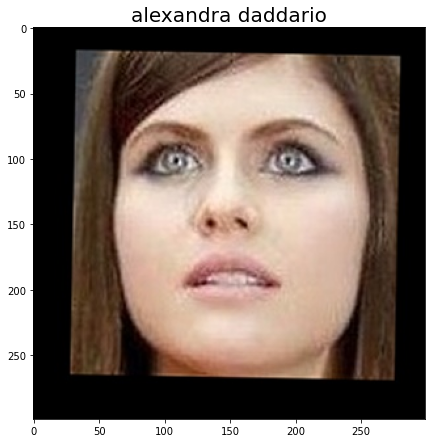

In [59]:
# Load a sample image

n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

In [60]:
load_image(metadata[0].image_path())

array([[[233, 188, 165],
        [231, 186, 163],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[232, 187, 164],
        [233, 188, 165],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[230, 186, 161],
        [228, 184, 159],
        [206, 164, 140],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       ...,

       [[198, 118,  91],
        [197, 120,  94],
        [195, 119,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[200, 120,  93],
        [200, 120,  93],
        [198, 121,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[201, 121,  94],
        [201, 121,  94],
        [199, 122,  96],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]]

#### 4. Generate Embeddings vectors on the each face in the dataset. [4 Marks]
Hint: Use ‘vgg_face_weights.h5’


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    #Clear out tensorflow memory
    tf.keras.backend.clear_session()
    cv_model = Sequential()
    cv_model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    cv_model.add(Convolution2D(64, (3, 3), activation='relu'))
    cv_model.add(ZeroPadding2D((1,1)))
    cv_model.add(Convolution2D(64, (3, 3), activation='relu'))
    cv_model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    cv_model.add(ZeroPadding2D((1,1)))
    cv_model.add(Convolution2D(128, (3, 3), activation='relu'))
    cv_model.add(ZeroPadding2D((1,1)))
    cv_model.add(Convolution2D(128, (3, 3), activation='relu'))
    cv_model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    cv_model.add(ZeroPadding2D((1,1)))
    cv_model.add(Convolution2D(256, (3, 3), activation='relu'))
    cv_model.add(ZeroPadding2D((1,1)))
    cv_model.add(Convolution2D(256, (3, 3), activation='relu'))
    cv_model.add(ZeroPadding2D((1,1)))
    cv_model.add(Convolution2D(256, (3, 3), activation='relu'))
    cv_model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    cv_model.add(ZeroPadding2D((1,1)))
    cv_model.add(Convolution2D(512, (3, 3), activation='relu'))
    cv_model.add(ZeroPadding2D((1,1)))
    cv_model.add(Convolution2D(512, (3, 3), activation='relu'))
    cv_model.add(ZeroPadding2D((1,1)))
    cv_model.add(Convolution2D(512, (3, 3), activation='relu'))
    cv_model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    cv_model.add(ZeroPadding2D((1,1)))
    cv_model.add(Convolution2D(512, (3, 3), activation='relu'))
    cv_model.add(ZeroPadding2D((1,1)))
    cv_model.add(Convolution2D(512, (3, 3), activation='relu'))
    cv_model.add(ZeroPadding2D((1,1)))
    cv_model.add(Convolution2D(512, (3, 3), activation='relu'))
    cv_model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    cv_model.add(Convolution2D(4096, (7, 7), activation='relu'))
    cv_model.add(Dropout(0.5))
    cv_model.add(Convolution2D(4096, (1, 1), activation='relu'))
    cv_model.add(Dropout(0.5))
    cv_model.add(Convolution2D(2622, (1, 1)))
    cv_model.add(Flatten())
    cv_model.add(Activation('softmax'))
    return cv_model

Load the model defined above

Then load the given weight file named "vgg_face_weights.h5"

In [62]:
cv_model = vgg_face()
cv_model.load_weights('vgg_face_weights.h5')
print(cv_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

Get vgg_face_descriptor

In [63]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=cv_model.layers[0].input, outputs=cv_model.layers[-2].output)

#### Generate embeddings for each image in the dataset

Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model.

In [64]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


#### Generate embeddings for all images

Write code to iterate through metadata and create embeddings for each image using vgg_face_descriptor.predict() and store in a list with name embeddings

If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [65]:
from tqdm import tqdm_notebook as tqdm
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

#### 5. Build distance metrics for identifying the distance between two similar and dissimilar images. [4 Marks]


### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [66]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

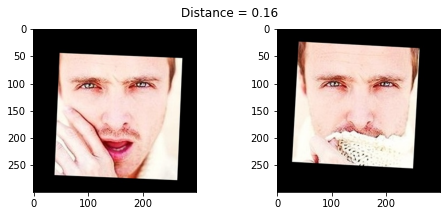

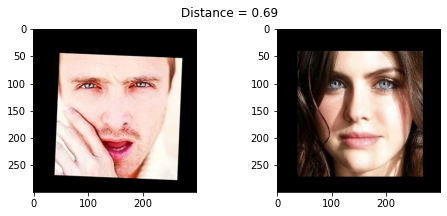

In [67]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

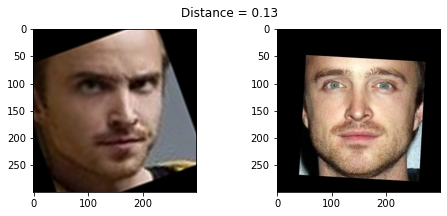

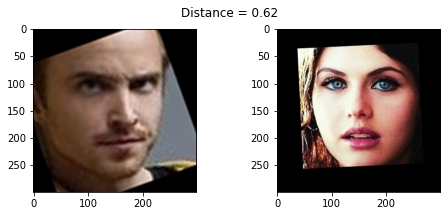

In [68]:
show_pair(30, 31)
show_pair(30, 100)

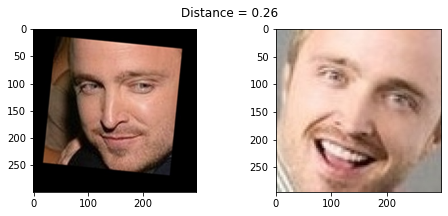

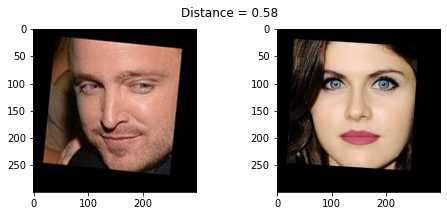

In [69]:
show_pair(70, 72)
show_pair(70, 115)

#### 6. Use PCA for dimensionality reduction. [2 Marks]


- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [70]:
#every 9th example goes in test data and rest go in train data
train_idx = np.arange(metadata.shape[0]) % 9 != 0     
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622) (1197, 2622) (9573,) (1197,)


### Encode the Labels
- Encode the targets
- Use LabelEncoder

In [71]:
from sklearn.preprocessing import LabelEncoder
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)


### Standardize the feature values
- Scale the features using StandardScaler

In [72]:
# Standarize features
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Reduce dimensions using PCA
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [73]:
from sklearn.decomposition import PCA


pca = PCA(n_components=128, svd_solver = 'full', whiten = True)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

In [74]:
df = pd.DataFrame(data = X_train_pca)
df

0         1         2         3         4         5         6    \
0    -0.741184  1.473493 -1.255782  0.046447 -0.991784 -0.661733 -0.580105   
1    -0.342968  1.446456 -0.904906  0.194219 -0.825007 -0.706478 -0.094370   
2    -0.951875  0.497434 -0.389898  0.305083 -0.823372 -0.642095 -0.387994   
3    -0.870432 -0.146127  0.059377 -0.233993 -0.737345 -0.257814 -0.369084   
4    -0.776622  0.170044  0.032830 -0.299725 -0.440005  0.391312 -0.361971   
...        ...       ...       ...       ...       ...       ...       ...   
9568  0.898696 -1.853022 -1.434983  0.414451  1.521666  0.596902 -0.018311   
9569  1.028853 -0.655180 -1.286429  2.274643  1.105993  0.657097  0.233735   
9570  1.106928 -1.805877 -1.761371  0.382334  0.978677  0.340029 -0.903554   
9571  0.899988 -1.823775 -1.255030  1.146922  0.347818  0.322702  0.335035   
9572  2.018023 -1.508039  0.281089  2.642943  1.057064  0.726624  0.272864   

           7         8         9    ...       118       119       120  \
0    -1.615836  0.464921  0.156238  ... -1.783531 -0.587280  0.006962   
1    -1.207932  1.026454  0.158659  ... -1.152812 -0.648351  0.003876   
2    -0.823829  0.614522  0.377950  ...  1.232167 -0.390454 -0.579107   
3    -0.714716 -0.209443  0.527405  ...  0.350034 -0.700669 -0.283705   
4    -0.810741  0.805309  1.012293  ... -0.262684 -1.881631 -0.045661   
...        ...       ...       ...  ...       ...       ...       ...   
9568  0.237220 -0.755342  0.185668  ... -0.112436 -1.307318  0.298007   
9569  0.525362 -1.041870  0.988482  ...  0.119593  0.784122 -0.054709   
9570 -0.838148  0.534752  0.638410  ... -0.275791 -0.146918  0.522782   
9571  0.422830 -0.420669  0.624344  ... -0.865264 -0.720929  0.781727   
9572  1.036424  0.801763  2.278658  ... -1.288618  1.786013  3.843886   

           121       122       123       124       125       126       127  
0     0.578439  0.743329 -0.789268 -1.267717  0.039228 -0.428653 -0.453230  
1     1.598289  1.372490 -0.776947 -1.084721 -1.306459  0.068159 -0.344987  
2    -0.148888  0.628981  0.375790 -1.542370 -0.921659 -1.547403 -0.530345  
3    -0.658149 -0.276329  1.102392 -2.520452 -0.252740 -1.286925 -1.298691  
4    -0.166079 -1.375223 -0.881717 -1.972845 -0.580349 -0.796275 -1.169675  
...        ...       ...       ...       ...       ...       ...       ...  
9568  0.652388 -1.660534  0.203585  1.066301 -1.550761 -0.013229  1.091681  
9569 -0.595814  0.527939 -0.039890 -0.039781 -0.730905 -1.598362 -0.545992  
9570 -2.169197 -0.327314  0.554972 -0.176623 -0.598253 -0.391015 -0.104612  
9571  0.094384 -0.350717  0.122249  0.470548 -0.701158 -0.996781  0.008595  
9572  1.978014 -1.239019  0.978652 -0.631888 -0.821395 -0.872473  0.621144  

[9573 rows x 128 columns]

#### 7. Build an SVM classifier in order to map each image to its right person. [4 Marks]


Use SVM Classifier to predict the person in the given image

Fit the classifier and print the score

In [75]:
from sklearn.svm import SVC
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', random_state = 42)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.976


In [76]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.955


In [77]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      0.86      0.92         7
               Anna Gunn       1.00      1.00      1.00        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       0.90      1.00      0.95         9
      Bellamy Blake Face       0.87      0.93      0.90        14
    Benedict Cumberbatch       0.92      0.92      0.92        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       1.00      1.00      

Thus, we are getting a train accuracy of 0.97 and test accuracy of 0.96, which means our model is a very good fit. Since, train and test accuracy is similar, the model is neither a overfit nor an underfit.

#### 8. Import and display the the test images. [2 Marks]
Hint: ‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ are the test images.


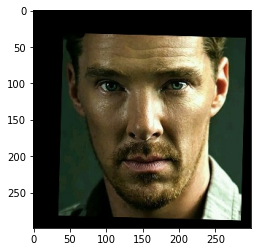

In [78]:
img = load_image('Benedict Cumberbatch9.jpg')
plt.imshow(img)

In [79]:
import copy
metadata_sr = copy.deepcopy(metadata)
for i in range(len(metadata)):
    metadata_sr[i] = str(metadata[i])

In [80]:
#Computing the index of the image from the metadata
index_BC = np.where(metadata_sr == 'PINS\pins_Benedict Cumberbatch\Benedict Cumberbatch9.jpg')[0][0]
print('Index of the first image is', index_BC)

Index of the first image is 1396


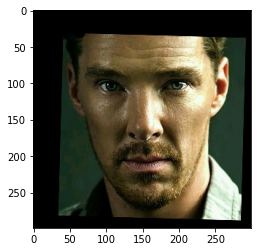

In [81]:
from matplotlib import image as mpimg
image_BC = mpimg.imread(metadata_sr[index_BC])
plt.imshow(image_BC)

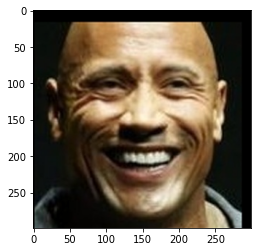

In [82]:
img = load_image('Dwayne Johnson4.jpg')
plt.imshow(img)

In [83]:
#Computing the index of the image from the metadata
index_DJ = np.where(metadata_sr == 'PINS\pins_Dwayne Johnson\Dwayne Johnson4.jpg')[0][0]
print('Index of the second image is',index_DJ)

Index of the second image is 3496


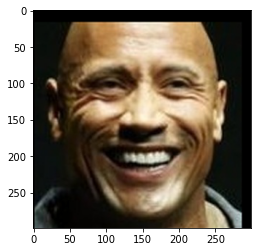

In [84]:
from matplotlib import image as mpimg
image_DJ = mpimg.imread(metadata_sr[index_DJ])
plt.imshow(image_DJ)

#### 9. Use the trained SVM model to predict the face on both test images. [4 Marks]

In [85]:
# Get embedding vector for first image in the metadata using the pre-trained model

img = load_image('Benedict Cumberbatch9.jpg')

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


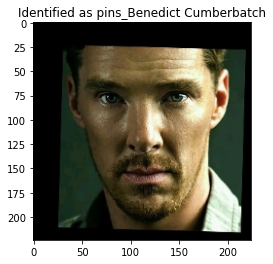

In [86]:
X_test_BC = np.array(embedding_vector)

X_test_BC = X_test_BC.reshape(1, -1)

X_test_BC_sc = sc.transform(X_test_BC)

X_test_BC_pca = pca.transform(X_test_BC_sc)

example_prediction = svc_pca.predict(X_test_BC_pca)
example_identity = en.inverse_transform(example_prediction)[0]

plt.imshow(img)
plt.title(f'Identified as {example_identity}');

In [87]:
# Get embedding vector for first image in the metadata using the pre-trained model

img = load_image('Dwayne Johnson4.jpg')

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


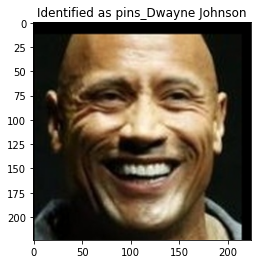

In [88]:
X_test_BC = np.array(embedding_vector)

X_test_BC = X_test_BC.reshape(1, -1)

X_test_BC_sc = sc.transform(X_test_BC)

X_test_BC_pca = pca.transform(X_test_BC_sc)

example_prediction = svc_pca.predict(X_test_BC_pca)
example_identity = en.inverse_transform(example_prediction)[0]

plt.imshow(img)
plt.title(f'Identified as {example_identity}');